## Field and Record Data (Tabular data)

Tabular data, that is data that is formatted as a table with a fixed number of rows and columns, is very common in a research context. A particularly simple and also popular file format for such data is [_delimited-separated value_ files](https://en.wikipedia.org/wiki/Delimiter-separated_values).

## Delimiter-separated values

Let's carry on with our sunspots example. As we saw previously the data is semicolon-separated. 

We can request the CSV file text from the URL we used previously:

In [1]:
import requests
# Request sunspots data from URL and extract response content as text
sunspots_csv_text = requests.get('http://www.sidc.be/silso/INFO/snmtotcsv.php').text
# Strip any leading or trailing whitespace from CSV text to skip any empty rows
sunspots_csv_text = sunspots_csv_text.strip()

As a quick check we can split the text on the newline character `\n` and print the last five entries in the resulting list

In [2]:
print(sunspots_csv_text.split('\n')[-5:])

['2022;07;2022.538;  91.4; 12.2; 1304;0', '2022;08;2022.623;  75.4; 10.5; 1289;0', '2022;09;2022.705;  96.3; 16.2; 1130;0', '2022;10;2022.790;  95.4; 15.5; 1028;0', '2022;11;2022.873;  77.6; 14.1;  881;0']


We see that each line is a string with numeric calues separted by semicolon delimiters. We want to work programmatically with such *delimited-separated value* files.

These are files which (typically) have

* One *record* per line (row)
* Each record has multiple *fields* (columns)
* Fields are separated by some *delimiter*

Typical separators are the `space`, `tab`, `comma`, and `semicolon`, leading to correspondingly-named file formats, e.g.:

* Space-separated value (e.g. `field1 "field two" field3` )
* Comma-separated value (e.g. `field1, another field, "wow, another field"`)

Comma-separated value is abbreviated CSV, and tab-separated value TSV.

CSV is also sometimes used to refer to all the different sub-kinds of separated value files, i.e. some people use CSV to refer to tab-, space- and semicolon-separated files.

CSV is not a particularly superb data format, because it forces your data model to only have two 'axes', records and fields, with each record a flat object. As we will see in the next notebook, structured file formats can be used to represent a richer array of data formats, including for example hierarchically structured data where each record may itself have an internal structure.

Nevertheless, because you can always export *spreadsheets* as CSV files (each cell is a field, each row is a record), CSV files are very popular. 

### CSV variants

Some CSV formats define a comment character, so that rows beginning with, e.g., a `#`, are not treated as data, but give a human comment.

Some CSV formats define a three-deep list structure, where a double-newline separates records into blocks.

Some CSV formats assume that the first line (also called a header) defines the names of the fields, e.g.:

```
name, age
James, 39
Will, 2
```

### Python `csv` module

The Python standard library provides a `csv` module for reading and writing delimited-separated value files, including, as the name suggests, CSV files. As it is built-in to all Python installations, it is useful to be familiar with the `csv` module as an option for loading and saving CSV formatted data, though the CSV capabilities in third-party libraries such as [NumPy](https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html) (which we will cover later in the course) and [Pandas](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) are more powerful and will often be better options in practice.

In [3]:
import csv

The most straightforward way to read CSV files using the `csv` module is with the [`csv.reader` function](https://docs.python.org/3/library/csv.html#csv.reader). This accepts an _iterable_ object as its first argument which returns a line of delimited input for each iteration. Commonly this will be an opened file object however it can also for example be a sequence of strings which is what we will use here by using the `split` method to convert the sunspot CSV text object into a list of per-line strings. The `csv.reader` function also accepts various optional keyword arguments including importantly a `delimiter` argument to specify the character used as the delimiter separating the values in each line, with we setting this to a semicolon here. 

In [4]:
csv_reader = csv.reader(sunspots_csv_text.split('\n'), delimiter=';')

The object returned by the `csv.reader` function is an iterator over the rows of the CSV file, with each row being returned as a list of the separated values in the row (with all values being read as strings by default). We can read all of the data in to a nested list-of-lists using a list comprehension:

In [5]:
sunspots_data = [row for row in csv_reader]
print(sunspots_data[-5:])

[['2022', '07', '2022.538', '  91.4', ' 12.2', ' 1304', '0'], ['2022', '08', '2022.623', '  75.4', ' 10.5', ' 1289', '0'], ['2022', '09', '2022.705', '  96.3', ' 16.2', ' 1130', '0'], ['2022', '10', '2022.790', '  95.4', ' 15.5', ' 1028', '0'], ['2022', '11', '2022.873', '  77.6', ' 14.1', '  881', '0']]


For this particular CSV file the first column corresponds to the measurement year, the second the measurement month number and the third the measurement date as a 'fractional year'. We can extract a list of the just the (fractional) years converted to floating point values using another list comprehension

In [6]:
fractional_years = [float(row[2]) for row in sunspots_data]

Similarly the fourth column in the CSV file contains the monthly mean total sunspot number, which we can extract with another list comprehension

In [7]:
monthly_mean_total_sunspot_numbers = [float(row[3]) for row in sunspots_data]

We can then for example use Matplotlib to create a plot of how the monthly average sunspot number varies over time, with this highlighting [the cyclic nature of sunspot activity](https://en.wikipedia.org/wiki/Solar_cycle)

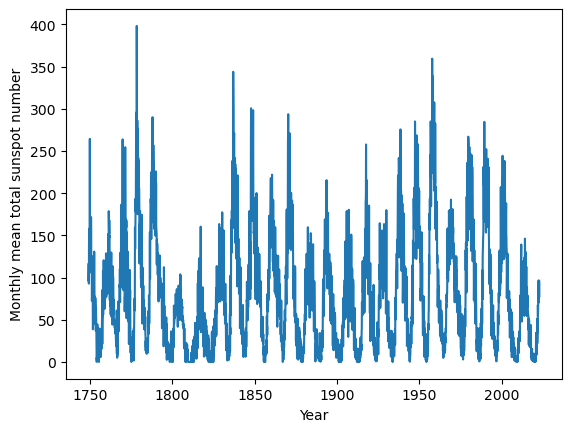

In [8]:
from matplotlib import pyplot as plt
plt.plot(fractional_years, monthly_mean_total_sunspot_numbers)
plt.xlabel('Year')
plt.ylabel('Monthly mean total sunspot number');

#### Reading rows as dictionaries

Accessing the values in each row by an index corresponding to their column can be unclear and prone to bugs. The `csv` module also provides the `csv.DictReader` class to allow reading each record (line) in the CSV file as a dictionary keyed by a set of field names. For the dataset we are using [we have the columns correspond to](http://www.sidc.be/silso/infosnmtot)

```
Column 1-2: Gregorian calendar date
- Year
- Month
Column 3: Date in fraction of year.
Column 4: Monthly mean total sunspot number.
Column 5: Monthly mean standard deviation of the input sunspot numbers.
Column 6: Number of observations used to compute the monthly mean total sunspot number.
Column 7: Definitive/provisional marker. '1' indicates that the value is definitive. '0' indicates that the value is still provisional.
```

We can create an instance of the `csv.DictReader` class very similarly to how we called the `csv.reader` function, but with an additional keyword argument `fieldnames` specifying a sequence of strings corresponding to the keys to associate the values in each row with. Below we also set the optional keyword argument `quoting` to the special constant `csv.QUOTE_NONNUMERIC` which causes all non-quoted values in each line to be automatically converted to floating point values.

In [9]:
csv_reader = csv.DictReader(
    sunspots_csv_text.split('\n'),
    fieldnames=['year', 'month', 'fractional_year', 'mean', 'deviation', 'observations', 'definitive'],
    delimiter=';',
    quoting=csv.QUOTE_NONNUMERIC
)

Similarly to previously we can now extract all the data using a list comprehension, with the difference being that each item in the constructed list is now a dictionary keyed by the field names:

In [10]:
sunspots_data = [record for record in csv_reader]
print(sunspots_data[-1])

{'year': 2022.0, 'month': 11.0, 'fractional_year': 2022.873, 'mean': 77.6, 'deviation': 14.1, 'observations': 881.0, 'definitive': 0.0}


We can then recreate the same plot as previously as follows, with the intention of the list comprehensions extracting the year and mean values now much more apparent

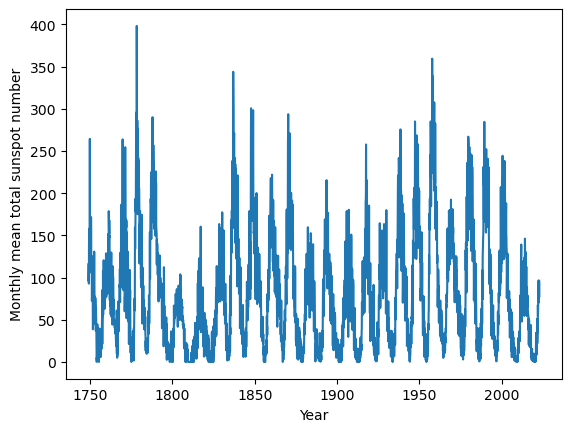

In [11]:
from matplotlib import pyplot as plt

plt.plot([r['fractional_year'] for r in sunspots_data], [r['mean'] for r in sunspots_data])
plt.xlabel('Year')
plt.ylabel('Monthly mean total sunspot number');

#### Writing CSV files

The `csv` module also provides functionality for writing delimiter-separated value files. The `csv.writer` function provides a simple interface for writing CSV files row by row, with the function accepting a file object (and optional keyword arugments specifying formatting options such as `delimiter`) and the returned object providing a `writerow` method to write a sequence of values to the file as a delimiter-separated string. For example we can save a table of data about the planets in the solar system as a comma-separated values file using the following code snippet

In [12]:
planets_data = [
    ['Name', 'Mean distance from sun / AU', 'Orbit period / years', 'Mass / M🜨', 'Radius / R🜨', 'Number of satellites'],
    ['Mercury', 0.39, 0.24, 0.06, 0.38, 0],
    ['Venus', 0.72, 0.62, 0.82, 0.95, 0],
    ['Earth', 1., 1., 1., 1., 1],
    ['Mars', 1.5, 1.9, 0.11, 0.53, 2],
    ['Jupiter', 5.2, 12., 320., 11., 63],
    ['Saturn', 9.5, 29., 95., 9.4, 61],
    ['Uranus', 19., 84., 15., 4.1, 27],
    ['Neptune', 30., 170., 17., 3.9, 14],
]

with open('planets_data.csv', 'w', encoding='utf-8') as f:
    csv_writer = csv.writer(f, delimiter=',')
    for row in planets_data:
        csv_writer.writerow(row)

A [`csv.DictWriter`](https://docs.python.org/3/library/csv.html#csv.DictWriter) class is also provided which analogously to the  `csv.DictReader` class, allows writing a CSV file using rows specified by dictionaries mapping from field names to values.

### NumPy's CSV readers

The Python standard library `csv` module seen in the preceding section is less powerful than the CSV capabilities in NumPy,
the main scientific Python library for handling data. NumPy is distributed with Anaconda and Canopy, so we recommend use that when available.

NumPy has powerful capabilities for handling matrices, and other fun stuff, and we'll learn about these later in the course,
but for now, we'll use NumPy's CSV reader, and assume it gives us lists and dictionaries, rather than its more exciting `array` type.

In [13]:
import numpy as np

In [14]:
spots = requests.get('http://www.sidc.be/silso/INFO/snmtotcsv.php', stream=True)

`stream=True` delays loading all of the data until it is required.

In [15]:
sunspots = np.genfromtxt(spots.raw, delimiter=';')

`genfromtxt` is a powerful CSV reader. We used the `delimiter` optional argument to specify the delimeter. We could also specify
`names=True` if we had a first line naming fields, and `comments=#` if we had comment lines.

In [16]:
sunspots[0][3]

96.7

As before, we can now plot the "Sunspot cycle", note how we can specify the column directly from the data we've read.

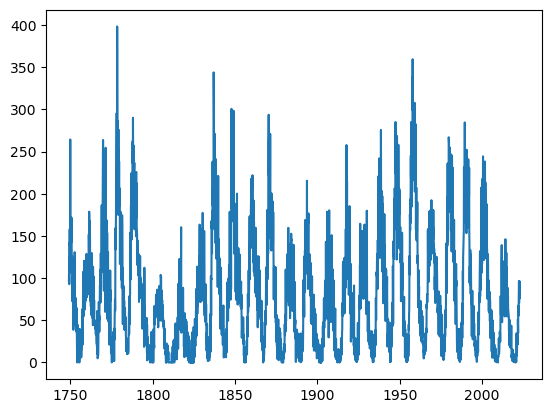

In [17]:
%matplotlib inline

from matplotlib import pyplot as plt
plt.plot(sunspots[:,2], sunspots[:,3]) # Numpy syntax to access all 
                                       # rows, specified column.

The plot command accepted an array of 'X' values and an array of 'Y' values. We used a special NumPy "`:`" syntax,
which we'll learn more about later. Don't worry about the `%matplotlib` magic command for now - we'll also look at this later.

`genfromtxt` also allows naming the columns. Similarly of what we've done with the `csv.DictReader`. We do that by specifying the column information to the formatter:

In [18]:
spots = requests.get('http://www.sidc.be/silso/INFO/snmtotcsv.php', stream=True)

sunspots = np.genfromtxt(spots.raw, delimiter=';', 
                         names=['year','month','date',
                         'mean','deviation','observations','definitive'])

In [19]:
sunspots

array([(1749.,  1., 1749.042,  96.7, -1. , -1.000e+00, 1.),
       (1749.,  2., 1749.123, 104.3, -1. , -1.000e+00, 1.),
       (1749.,  3., 1749.204, 116.7, -1. , -1.000e+00, 1.), ...,
       (2022.,  9., 2022.705,  96.3, 16.2,  1.130e+03, 0.),
       (2022., 10., 2022.79 ,  95.4, 15.5,  1.028e+03, 0.),
       (2022., 11., 2022.873,  77.6, 14.1,  8.810e+02, 0.)],
      dtype=[('year', '<f8'), ('month', '<f8'), ('date', '<f8'), ('mean', '<f8'), ('deviation', '<f8'), ('observations', '<f8'), ('definitive', '<f8')])

Going a step further, as we know what's expected on each column, it's then good to specify the datatype of each field.

In [20]:
spots = requests.get('http://www.sidc.be/silso/INFO/snmtotcsv.php', stream=True)

sunspots = np.genfromtxt(spots.raw, delimiter=';', 
                         names=['year','month','date',
                         'mean','deviation','observations','definitive'],
                         dtype=[int, int, float, float, float, int, int])

In [21]:
sunspots

array([(1749,  1, 1749.042,  96.7, -1. ,   -1, 1),
       (1749,  2, 1749.123, 104.3, -1. ,   -1, 1),
       (1749,  3, 1749.204, 116.7, -1. ,   -1, 1), ...,
       (2022,  9, 2022.705,  96.3, 16.2, 1130, 0),
       (2022, 10, 2022.79 ,  95.4, 15.5, 1028, 0),
       (2022, 11, 2022.873,  77.6, 14.1,  881, 0)],
      dtype=[('year', '<i4'), ('month', '<i4'), ('date', '<f8'), ('mean', '<f8'), ('deviation', '<f8'), ('observations', '<i4'), ('definitive', '<i4')])

Now, NumPy understands the names of the columns, so our plot command is more readable:

In [22]:
sunspots['year']

array([1749, 1749, 1749, ..., 2022, 2022, 2022])

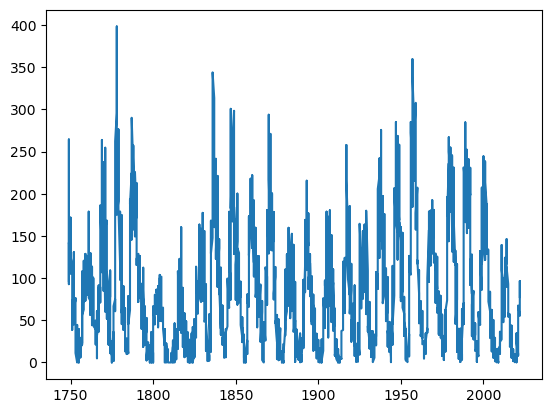

In [23]:
plt.plot(sunspots['year'], sunspots['mean'])

### Pandas - a more powerful CSV reader

If most of your work is going to be working with CSV files, then, most probably you will enjoy the powers that [pandas](https://pandas.pydata.org/) provide. Whereas numpy uses arrays, pandas work with [DataFrames](https://pandas.pydata.org/pandas-docs/stable/getting_started/intro_tutorials/01_table_oriented.html), that's how they name to their representation of data in a table (2D arrays).

Let's see how we would use it for this example.

In [24]:
import pandas as pd

spots = requests.get('http://www.sidc.be/silso/INFO/snmtotcsv.php', stream=True)

sunspots = pd.read_csv(spots.raw, delimiter=';',
                       names=['year','month','date',
                               'mean','deviation','observations','definitive'])
sunspots

,year,month,date,mean,deviation,observations,definitive
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1
...,...,...,...,...,...,...,...
3282,2022,7,2022.538,91.4,12.2,1304,0
3283,2022,8,2022.623,75.4,10.5,1289,0
3284,2022,9,2022.705,96.3,16.2,1130,0
3285,2022,10,2022.790,95.4,15.5,1028,0


In pandas, then you can access to the data of their columns as with a dictionaries.

In [25]:
sunspots['year']

0       1749
1       1749
2       1749
3       1749
4       1749
        ... 
3282    2022
3283    2022
3284    2022
3285    2022
3286    2022
Name: year, Length: 3287, dtype: int64

And ploting the data is directly available from the object.

<AxesSubplot: xlabel='year'>

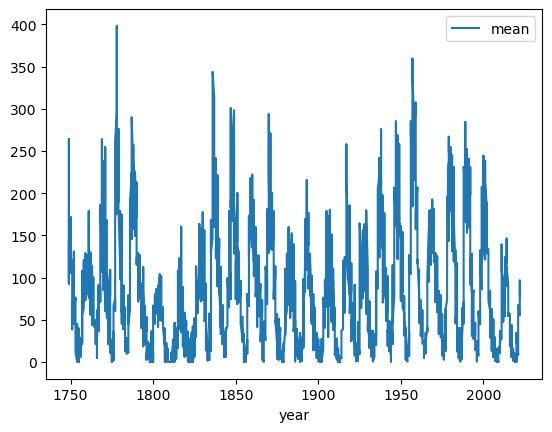

In [26]:
sunspots.plot('year', 'mean')

Note how, automatically, pandas sets the axis labels and the legend. We will learn how to set these up later in this chapter.

You can learn more about pandas with the [Software carpentry's Plotting and Programming with Python](https://swcarpentry.github.io/python-novice-gapminder/) lesson.